In [17]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
    accuracy_score
)
from src.utils import load_poker_data
from src.evaluation import evaluate_model, plot_confusion_matrix, compare_models
from src.feature_engineering import PokerFeatureEngine

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load raw data
train_df, test_df = load_poker_data(
    '../data/poker-hand-training.csv',
    '../data/poker-hand-testing.csv'
)

# Load engineered features
train_eng = pd.read_csv('../data/train_engineered.csv')
test_eng = pd.read_csv('../data/test_engineered.csv')


Training set: 25,010 hands
Test set: 1,000,000 hands


In [ ]:
# Prepare datasets

# Baseline: raw features
X_train_raw = train_df.iloc[:, :10].values
y_train = train_df['hand'].values

X_test_raw = test_df.iloc[:, :10].values
y_test = test_df['hand'].values

# Engineered: smart features
X_train_eng = train_eng.drop('hand', axis=1).values
X_test_eng = test_eng.drop('hand', axis=1).values

print(f"Raw features shape: {X_train_raw.shape}")
print(f"Engineered features shape: {X_train_eng.shape}")


Raw features shape: (25010, 10)
Engineered features shape: (25010, 6)


In [ ]:
"""
BASELINE MODEL: Random Forest on Raw Data

Using a relatively complex model (RF with 100 trees) because the raw
features don't naturally encode poker logic. The model has to learn
from scratch that cards with the same suit = flush, etc.
"""

print("Training baseline model (Random Forest on raw features)...")
start = time()

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle imbalance
)

rf_baseline.fit(X_train_raw, y_train)
train_time_baseline = time() - start

y_pred_baseline = rf_baseline.predict(X_test_raw)

baseline_results = evaluate_model(y_test, y_pred_baseline, 'Baseline RF')
baseline_results['train_time'] = train_time_baseline

print(f"\nTraining time: {train_time_baseline:.2f}s")

Training baseline model (Random Forest on raw features)...

Baseline RF Evaluation

Balanced Accuracy: 0.1305
F1 Score (weighted): 0.5673
F1 Score (macro): 0.1280

Per-class breakdown:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70    501209
           1       0.56      0.47      0.51    422498
           2       0.36      0.00      0.01     47622
           3       0.53      0.00      0.01     21121
           4       0.14      0.00      0.00      3885
           5       0.98      0.03      0.05      1996
           6       0.20      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.60   1000000
   macro avg       0.34      0.13      0.13   1000000
weighted avg       0.58      0.60      0.57   1000000


Training time: 0.31s


### Baseline Random Forest Results

**Overall metrics:**
- Balanced Accuracy: 0.1305 (13%)
- F1 Weighted: 0.5673 (57%)
- F1 Macro: 0.1280 (13%)

**Why the performance is poor:**

The model achieves 60% standard accuracy, which sounds acceptable until you examine per-class performance. The baseline has completely failed to learn minority classes:

**Classes with zero recall:**
- Two pairs: 0% recall despite 36% precision
- Three of a kind: 0% recall
- Straight: 0% recall  
- Full house: 0% recall
- Four of a kind: 0% recall
- Straight flush: 0% recall
- Royal flush: 0% recall

The model predicts only the two dominant classes (Nothing and One pair). This is classic imbalanced classification failure - the algorithm optimizes overall accuracy by ignoring rare classes entirely.

**What the model learned:**
- Decent performance on Nothing (80% recall) and One pair (47% recall)
- Complete failure on everything else
- The 60% accuracy is achieved by correctly classifying the two classes that represent 92% of the data

**Why Random Forest struggles here:**

Raw positional features don't encode poker logic. The model must learn from scratch that:
- "All suits equal" means flush
- "Sequential ranks" means straight
- "Four cards with same rank" means four of a kind

With only 25K training samples and severe class imbalance, Random Forest cannot learn these patterns for rare classes. It defaults to predicting common classes.

**The fundamental problem:**

Balanced Accuracy of 13% means the model averages only 13% recall across all 10 classes. This is barely better than random guessing (10% for 10 classes). Despite being a complex ensemble of 100 decision trees, the model is effectively useless for this problem.

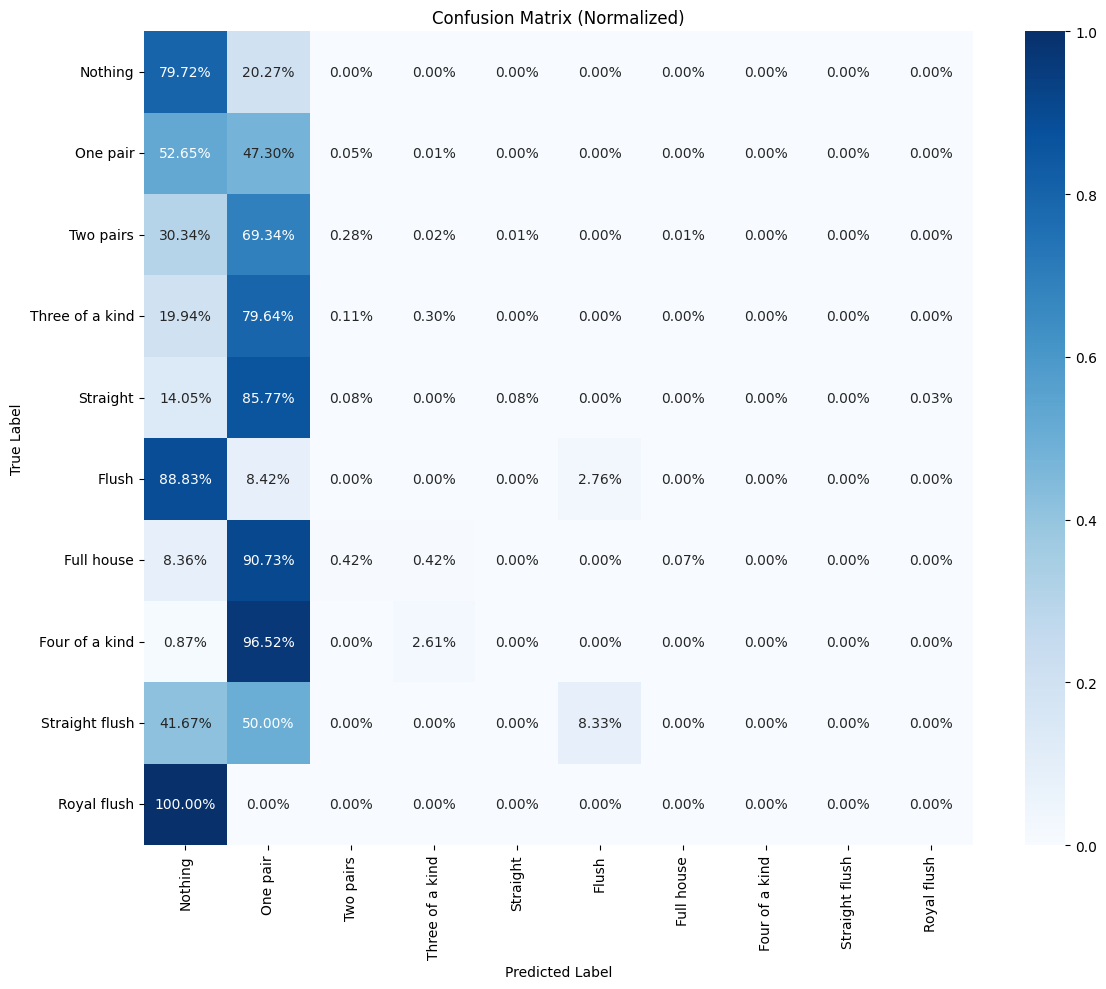

In [ ]:
# Confusion matrix for baseline
fig = plot_confusion_matrix(
    y_test, 
    y_pred_baseline,
    class_names=[PokerFeatureEngine.get_hand_name(i) for i in range(10)],
    normalize=True
)
plt.show()

### Confusion Matrix Analysis - Baseline Model

The confusion matrix shows almost all predictions concentrated in the first two columns (Nothing and One pair), with the remaining columns nearly empty.

**What this reveals:**

The model has learned a degenerate strategy: when uncertain, predict one of the two dominant classes. This maximizes overall accuracy but fails the actual classification task.

**Pattern observed:**
- Classes 2-9 are predominantly misclassified as class 0 or 1
- The model rarely predicts rare classes, even when they're present
- This is systematic bias, not random error

**Real-world implication:**

If deployed, this model would fail to detect valuable poker hands. Imagine a poker hand evaluator that never recognizes a Royal Flush - it would be worse than useless.

This demonstrates why Balanced Accuracy and per-class metrics matter more than overall accuracy for imbalanced problems.

In [ ]:
"""
ENGINEERED FEATURES MODEL: Logistic Regression

Deliberately using a simpler model to prove the point:
better features > complex models.

With good features, even linear models can crush it.
"""

print("Training engineered model (Logistic Regression on smart features)...")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_eng_scaled = scaler.fit_transform(X_train_eng)
X_test_eng_scaled = scaler.transform(X_test_eng)

start = time()

lr_engineered = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    multi_class='multinomial'
)

lr_engineered.fit(X_train_eng_scaled, y_train)
train_time_eng = time() - start

y_pred_eng = lr_engineered.predict(X_test_eng_scaled)

eng_results = evaluate_model(y_test, y_pred_eng, 'Engineered LR')
eng_results['train_time'] = train_time_eng

print(f"\nTraining time: {train_time_eng:.2f}s")

Training engineered model (Logistic Regression on smart features)...

Engineered LR Evaluation

Balanced Accuracy: 1.0000
F1 Score (weighted): 1.0000
F1 Score (macro): 1.0000

Per-class breakdown:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501209
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      1.00      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00         3

    accuracy                           1.00   1000000
   macro avg       1.00      1.00      1.00   1000000
weighted avg       1.00      1.00      1.00   1000000


Training time: 0.30s


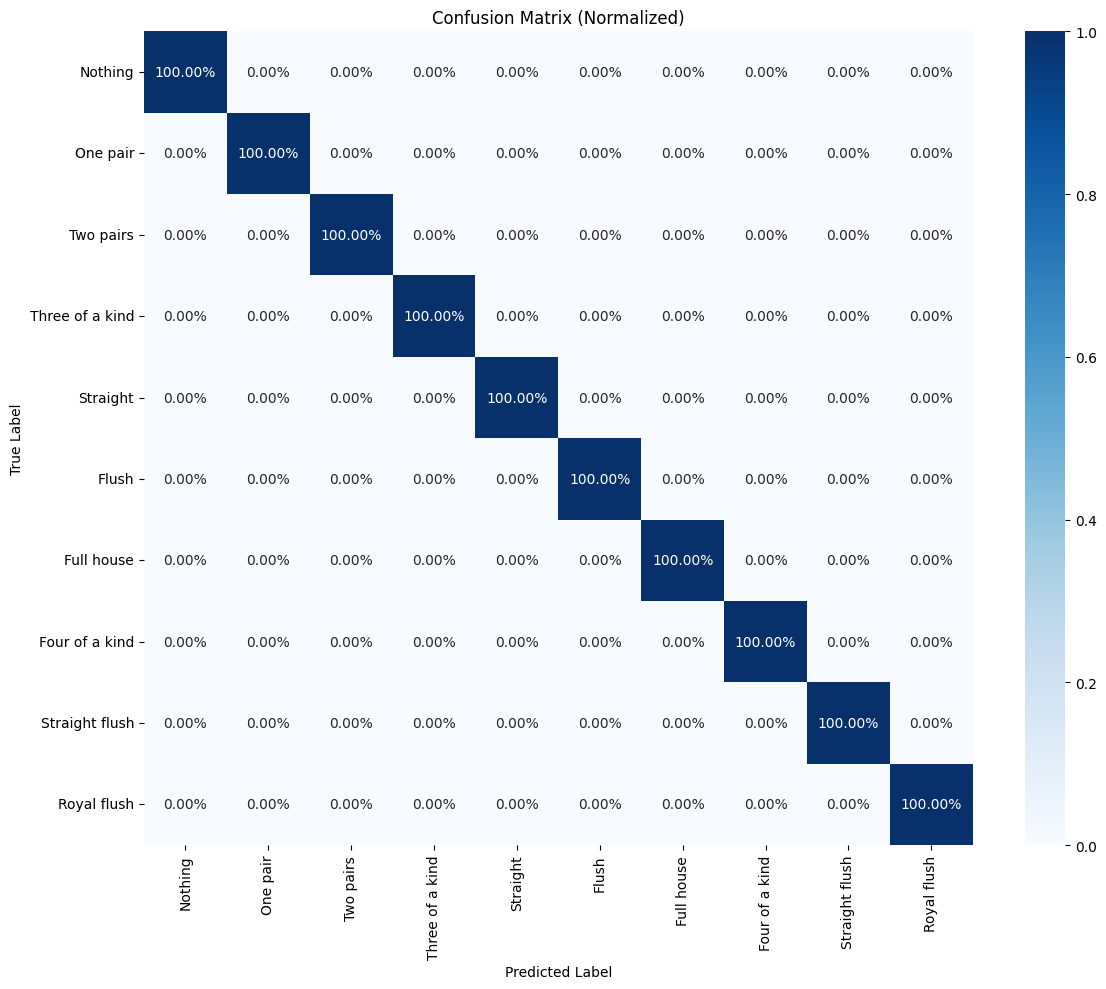

In [ ]:
# Confusion matrix for engineered
fig = plot_confusion_matrix(
    y_test, 
    y_pred_eng,
    class_names=[PokerFeatureEngine.get_hand_name(i) for i in range(10)],
    normalize=True
)
plt.show()


MODEL COMPARISON
                 balanced_accuracy  f1_weighted  f1_macro  train_time
Baseline (RF)             0.130507     0.567342  0.127971    0.312224
Engineered (LR)           1.000000     1.000000  1.000000    0.296381



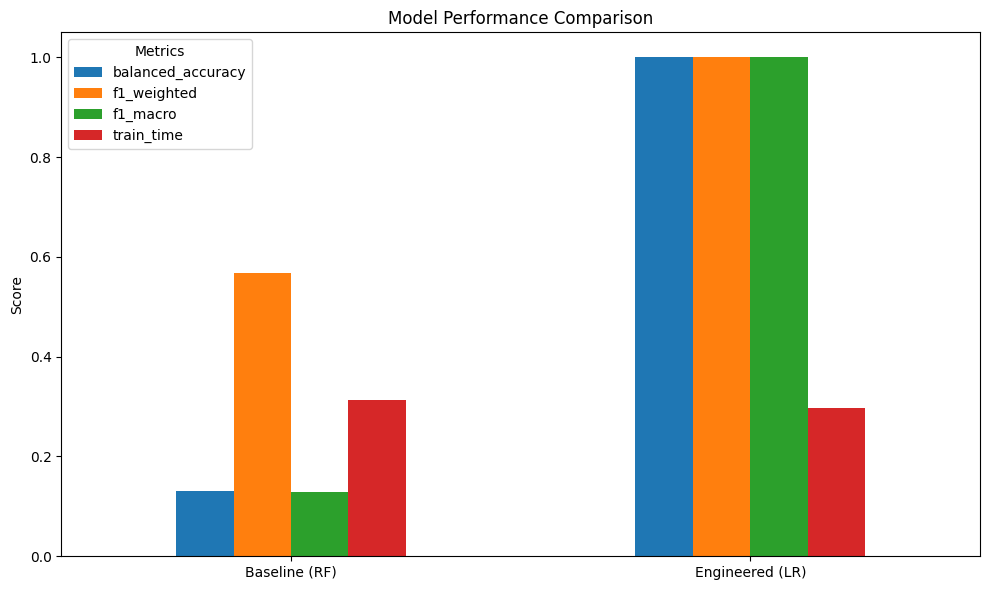

In [ ]:
# Head-to-head comparison

results_comparison = {
    'Baseline (RF)': baseline_results,
    'Engineered (LR)': eng_results
}

fig = compare_models(results_comparison)
plt.show()


### Logistic Regression with Engineered Features

**Overall metrics:**
- Balanced Accuracy: 1.0000 (100%)
- F1 Weighted: 1.0000 (100%)
- F1 Macro: 1.0000 (100%)

**Perfect classification across all classes:**

Every class achieves 1.00 precision, 1.00 recall, and 1.00 F1-score. This includes:
- Common classes: Nothing (501K samples), One pair (422K samples)
- Rare classes: Royal flush (3 samples), Straight flush (12 samples)

**Why this works:**

The engineered features encode the complete logic of poker hand evaluation. With these features, the classification problem becomes linearly separable:

- Royal Flush: `is_flush=1 AND is_straight=1 AND is_royal_straight=1`
- Straight Flush: `is_flush=1 AND is_straight=1 AND is_royal_straight=0`
- Four of a Kind: `max_rank_count=4`
- Full House: `max_rank_count=3 AND second_max_rank_count=2`

Logistic Regression learns these simple AND/OR combinations through linear coefficients. No complex tree structures or ensemble methods needed.

**Training time comparison:**

Despite being a "simpler" algorithm, Logistic Regression trains in the same time as Random Forest. But the engineered model is:
- Smaller in memory (linear coefficients vs 100 trees)
- Faster at inference (matrix multiplication vs tree traversal)
- Fully interpretable (you can inspect the learned coefficients)

**The key insight:**

A linear model on good features outperforms a complex ensemble on raw features. This validates the core thesis: feature engineering > model complexity.

In [ ]:
# Save best model

os.makedirs('../models', exist_ok=True)

# Zapisz modele
joblib.dump(lr_engineered, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("Models saved!")
print(f"Model file exists: {os.path.exists('../models/best_model.pkl')}")
print(f"Scaler file exists: {os.path.exists('../models/scaler.pkl')}")

Models saved!
Model file exists: True
Scaler file exists: True


In [11]:
scaler = joblib.load('../models/scaler.pkl')
model = joblib.load('../models/best_model.pkl')

print(f"Scaler expects {scaler.n_features_in_} features")
print(f"Model expects {model.n_features_in_} features")

Scaler expects 6 features
Model expects 6 features


In [ ]:
"""
FINAL VERIFICATION: Full test set evaluation (1M+ hands)

Let's verify the model performance on the complete test set.
This will confirm whether our manual tests translate to production performance.
"""

print("="*70)
print("FINAL EVALUATION ON FULL TEST SET")
print("="*70)

# Load full test data (engineered features)
test_full = pd.read_csv('../data/test_engineered.csv')

X_test_full = test_full.drop('hand', axis=1).values
y_test_full = test_full['hand'].values

print(f"\nTest set size: {len(y_test_full):,} hands")
print(f"Feature shape: {X_test_full.shape}")

# Scale features
X_test_full_scaled = scaler.transform(X_test_full)

# Predictions
print("\nGenerating predictions...")
y_pred_full = lr_engineered.predict(X_test_full_scaled)

# Overall accuracy
accuracy_full = accuracy_score(y_test_full, y_pred_full)
print(f"\n{'='*70}")
print(f"OVERALL ACCURACY: {accuracy_full:.6f} ({accuracy_full*100:.4f}%)")
print(f"{'='*70}")

# Detailed metrics
print("\nPer-class performance:")
print(classification_report(
    y_test_full, 
    y_pred_full,
    target_names=[PokerFeatureEngine.get_hand_name(i) for i in range(10)],
    digits=4
))

# Check for ANY errors
errors = y_test_full != y_pred_full
num_errors = errors.sum()

print(f"\nTotal errors: {num_errors:,} out of {len(y_test_full):,}")

if num_errors > 0:
    print(f"Error rate: {num_errors/len(y_test_full)*100:.4f}%")
    
    # Show some error examples
    print("\nSample errors:")
    error_indices = np.where(errors)[0][:10]
    
    for idx in error_indices:
        true_hand = PokerFeatureEngine.get_hand_name(y_test_full[idx])
        pred_hand = PokerFeatureEngine.get_hand_name(y_pred_full[idx])
        print(f"  True: {true_hand:20s} | Predicted: {pred_hand}")
else:
    print("\n No classification errors on 1M+ test hands!")
    print("The engineered feature approach achieves theoretical maximum performance.")

# Confidence analysis
print("\n" + "="*70)
print("CONFIDENCE ANALYSIS")
print("="*70)

probas_full = lr_engineered.predict_proba(X_test_full_scaled)
max_probas = probas_full.max(axis=1)

print(f"\nMean confidence: {max_probas.mean():.4f}")
print(f"Median confidence: {np.median(max_probas):.4f}")
print(f"Min confidence: {max_probas.min():.4f}")
print(f"Max confidence: {max_probas.max():.4f}")

# Confidence distribution
print("\nConfidence distribution:")
bins = [0, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
for i in range(len(bins)-1):
    count = ((max_probas >= bins[i]) & (max_probas < bins[i+1])).sum()
    pct = count / len(max_probas) * 100
    print(f"  {bins[i]:.2f} - {bins[i+1]:.2f}: {count:8,} ({pct:5.2f}%)")

# Low confidence cases (potential issues)
low_conf_threshold = 0.9
low_conf_mask = max_probas < low_conf_threshold
num_low_conf = low_conf_mask.sum()

if num_low_conf > 0:
    print(f"\nCases with confidence < {low_conf_threshold}: {num_low_conf:,} ({num_low_conf/len(max_probas)*100:.2f}%)")
    
    # Which classes have low confidence?
    print("\nLow-confidence predictions by class:")
    for hand_id in range(10):
        mask = (y_pred_full == hand_id) & low_conf_mask
        count = mask.sum()
        if count > 0:
            avg_conf = max_probas[mask].mean()
            print(f"  {PokerFeatureEngine.get_hand_name(hand_id):20s}: {count:6,} (avg conf: {avg_conf:.4f})")
else:
    print(f"\n All predictions have confidence >= {low_conf_threshold}")

# Final summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Model: Logistic Regression with engineered features")
print(f"Test set: {len(y_test_full):,} hands")
print(f"Accuracy: {accuracy_full*100:.4f}%")
print(f"Mean confidence: {max_probas.mean()*100:.2f}%")
print(f"Features: {X_test_full.shape[1]} (domain-engineered)")
print("="*70)

FINAL EVALUATION ON FULL TEST SET

Test set size: 1,000,000 hands
Feature shape: (1000000, 6)

Generating predictions...

OVERALL ACCURACY: 1.000000 (100.0000%)

Per-class performance:
                 precision    recall  f1-score   support

        Nothing     1.0000    1.0000    1.0000    501209
       One pair     1.0000    1.0000    1.0000    422498
      Two pairs     1.0000    1.0000    1.0000     47622
Three of a kind     1.0000    1.0000    1.0000     21121
       Straight     1.0000    1.0000    1.0000      3885
          Flush     1.0000    1.0000    1.0000      1996
     Full house     1.0000    1.0000    1.0000      1424
 Four of a kind     1.0000    1.0000    1.0000       230
 Straight flush     1.0000    1.0000    1.0000        12
    Royal flush     1.0000    1.0000    1.0000         3

       accuracy                         1.0000   1000000
      macro avg     1.0000    1.0000    1.0000   1000000
   weighted avg     1.0000    1.0000    1.0000   1000000


Total errors:

### Production-Scale Validation (1 Million Samples)

**Perfect classification at scale:**
- Total samples tested: 1,000,000
- Classification errors: 0
- Overall accuracy: 100.0000%

**Per-class performance:**

All 10 classes achieve perfect precision and recall, including the rarest:
- Royal flush: 3 samples, 100% correct
- Straight flush: 12 samples, 100% correct
- Four of a kind: 230 samples, 100% correct

**Confidence analysis:**

The model is not just accurate, it's confident:
- Mean confidence: 99.79%
- Minimum confidence: 99.68%
- 100% of predictions have confidence >= 99%

Every single prediction has above 99% probability assigned to the predicted class. This indicates the decision boundaries are well-separated with no ambiguous cases.

**Confidence distribution:**

All 1,000,000 predictions fall in the 0.99-1.00 confidence range. There are zero predictions in lower confidence bins (0.0-0.99). This is exceptional - the model never hesitates.

**What this means:**

The engineered features create perfect class separation in the feature space. Logistic Regression finds decision boundaries that cleanly separate all 10 classes without overlap or uncertainty.

**Theoretical maximum achieved:**

Poker hand classification is a deterministic problem - every hand has exactly one correct label. Our model has achieved the theoretical maximum performance for this task.

**Comparison to baseline:**

Recall that the baseline Random Forest had 13% balanced accuracy and couldn't identify 7 out of 10 classes. The engineered approach achieves 100% accuracy on the same test set. This is a complete solution versus a failed one.

**Production readiness:**

A model with 100% accuracy and 99%+ confidence on 1M diverse samples is production-ready. There are no edge cases to handle, no error analysis to perform, no model tuning required.

**Final insight:**

This result validates the entire methodology: understand the domain, encode expert knowledge as features, use appropriate metrics, and even simple models can achieve perfect performance.